training_params: theta, ['theta[0]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]', 'theta[7]']


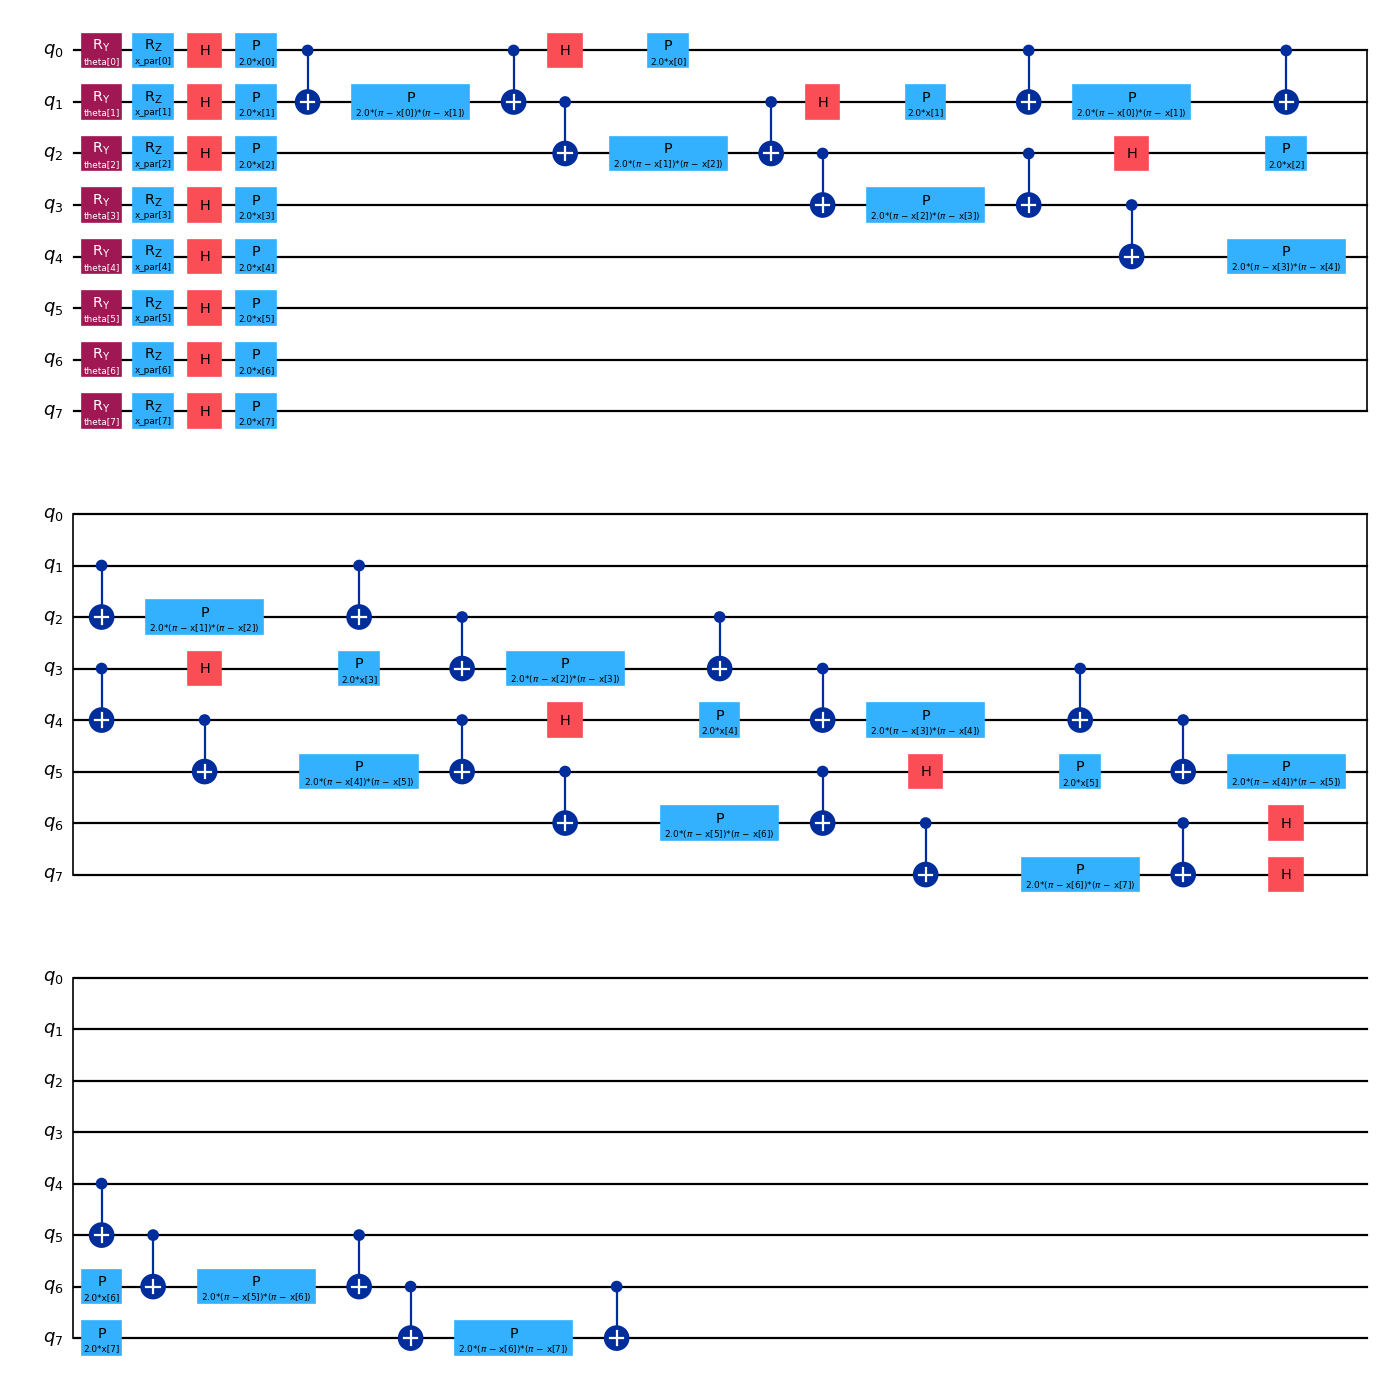

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZZFeatureMap

NUM_QUBITS = 8

# Set parameter vectors
input_params = ParameterVector('x_par', length=NUM_QUBITS)
training_params = ParameterVector('theta', length=8)

# Create a feature map

zz_feat_map = ZZFeatureMap(feature_dimension= NUM_QUBITS, reps=2, entanglement="linear")

# Append trainable ry gates to the start of the circuit.
feature_map = QuantumCircuit(NUM_QUBITS)
for i in range(8):
    feature_map.ry(training_params[i], i)


for j in range(NUM_QUBITS):
    feature_map.rz(input_params[j], j)


feature_map = feature_map.compose(zz_feat_map.decompose())
print(f"training_params: {training_params}")
feature_map.draw("mpl", scale=0.8)

In [232]:
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

qk = TrainableFidelityQuantumKernel(feature_map=feature_map, training_parameters=training_params)

print(training_params)


theta, ['theta[0]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]', 'theta[7]']


In [233]:
import numpy as np
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer

# Use SPSA to optimize the user parameters
spsa_opt = SPSA(maxiter=20, learning_rate=0.03, perturbation=0.01)

# Set up loss obj and pass a parameter to underlying sklearn.svm.svc
loss_func = SVCLoss(C=16.0)

# Instantiate QKT object with the fields required for training
qkt = QuantumKernelTrainer(
                           quantum_kernel=qk,
                           loss=loss_func,
                           optimizer=spsa_opt,
                           initial_point=[np.pi/2] * NUM_QUBITS,
       )




In [234]:
# prepare the data
import pandas as pd

# File paths
features_file = "carc_16comp_x.csv"
labels_file = "carc_16comp_y.csv"

# Load the data
features_df = pd.read_csv(features_file)
labels_df = pd.read_csv(labels_file)

from sklearn.model_selection import train_test_split

labels = labels_df.values.ravel()

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)

# Check shape of data
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((268, 16), (67, 16), (268,), (67,))

In [235]:
#Train the kernel

results = qkt.fit(X_train, y_train)
optimized_kernel = results.quantum_kernel

KeyboardInterrupt: 

In [153]:
# Use QSVC to evaluate the kernel we learned
from sklearn import metrics

from qiskit_machine_learning.algorithms import QSVC
qsvc = QSVC(quantum_kernel=optimized_kernel)
# Fit the QSVC
qsvc.fit(X_train, y_train)
# Predict the labels
y_pred = qsvc.predict(X_test)
# Evaluate the accuracy on test set
accuracy = metrics.balanced_accuracy_score(
                                    y_true=y_test,
                                    y_pred=y_pred
                    )
print(f"Accuracy: {accuracy}")

KeyboardInterrupt: 